# Relax Inc. Data Science Challenge

## < Question >

Defining an **"adopted user"** as a user who has logged into the product on **three separate days in at least one seven-day** period, **identify which factors predict future user adoption**.

## < Datasets >

### Two datasets:

**A user table ("takehome_users.csv")**  
12,000 users who signed up for the product in the last two years.  
This table includes:  
● name: the user's name  
● object_id: the user's id  
● email: email address  
● creation_source: how their account was created.  
This takes on one of  5  values:  
  ○ PERSONAL_PROJECTS: invited to join another user's personal workspace  
  ○ GUEST_INVITE: invited to an organization as a guest (limited  permissions)  
  ○ ORG_INVITE: invited to an organization (as a full member)  
  ○ SIGNUP: signed up via the website  
  ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)  
● creation_time: when they created their account  
● last_session_creation_time: Unix timestamp of last login  
● opted_in_to_mailing_list: whether they have opted into receiving marketing emails  
● enabled_for_marketing_drip: whether they are on the regular marketing email drip  
● org_id: the organization (group of users) they belong to  
● invited_by_user_id: which user invited them to join (if applicable).


**A  usage  summary  table  ( "takehome_user_engagement" )**  
A row represents a user logging into the product for each day.

## 1. Data Cleaning and Exploratory Data Analysis

In [1]:
# Import the packages
%matplotlib notebook

# EDA or data preparation
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, cv, plot_importance

# Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Set a style for a plot
sns.set(context='notebook', style='ticks', palette='hls')

Load two datasets and check the contents briefly.

In [2]:
# Load 'takehome_users.csv' 
df_users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Check the general information
print(df_users.info())

# Check if there are duplicate rows
print('Duplicate values:', df_users.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None
Duplicate values: False    12000
dtype: int64


Two columns ("last_session_creation_time" and "invited_by_user_id") have missing values. There is no duplicate row. This dataset includes **12k users**.

In [4]:
# Load 'takehome_user_engagement.csv'
df_log = pd.read_csv('takehome_user_engagement.csv', encoding='ISO-8859-1')
df_log.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# Check the general information
print(df_log.info())

# Check if there are duplicate rows
print('Duplicate values:', df_log.duplicated().value_counts())

# Show the number of users in this dataset
print('Number of users:', len(df_log.groupby('user_id')))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None
Duplicate values: False    207917
dtype: int64
Number of users: 8823


The log data did not have any missing value or duplicate value. This dataset included **logs from 8,823 users**. According to `df_users`, **12k users were registered**. **The rest of the users (3,177) did not sign in this period**. Also, the "last_session_creation_time" column in `df_users` had 8,823 values. The 8,823 values would be for the users who signed in the log tracking period. The missing values would mean that the user never signed into the system.   
  
To identify if users are adopted, first, change the "time_stamp" column into a datetime object. Second, make a new column storing date objects.

In [6]:
# Convert the values of the "time_stamp" into a datetime object
df_log['time_stamp'] = pd.to_datetime(df_log['time_stamp'])

# Make a new column "date" storing date objects 
df_log['date'] = df_log['time_stamp'].dt.floor("D")

# Make a new DataFrame having three columns
df_log_day = df_log[['user_id', 'visited', 'date']].copy()

# Drop duplicate rows (some users might loggin twice a day)
df_log_day.drop_duplicates()
df_log_day.head()

,user_id,visited,date
0,1,1,2014-04-22
1,2,1,2013-11-15
2,2,1,2013-11-29
3,2,1,2013-12-09
4,2,1,2013-12-25


In [7]:
# Show the date range
print('Date range:', df_log_day['date'].min(), 'to', df_log_day['date'].max())

Date range: 2012-05-31 00:00:00 to 2014-06-06 00:00:00


An "adopted user" is defined as a user who has logged into the product on three separate days in at least one seven-day period. Make a dictionary that stores "user_id"s as the keys and statuses (0: inactive, 1: active) as the values.

In [8]:
# Groupby 'user_id'
df_log_groupbyUser = df_log_day.groupby('user_id')

# Make a dictionary that stores "user_id"s as the keys and 0s as the values (0: inactive)
status = {i:0 for i in range(1, 12001)}

# Make a dictionary that stores "user_id"s and statuses (0: inactive, 1: active)
for tup in tqdm(df_log_groupbyUser):
    df = tup[1]
    df = df.sort_values('date')
    days = df['date'].diff(2)
    user = list(df['user_id'])[0]
    
    if days.min() <= timedelta(days=7):
        status[user] = 1

100%|████████████████████████████████████| 8823/8823 [00:04<00:00, 1796.05it/s]


In [9]:
# Check the number of users
print('Number of users:', len(status))

# Show the number of adopted users
n_adopted_users = list(status.values()).count(1)
print('Number of adopted users:', n_adopted_users)

# Show the rate of adopted users
print('Rate of adopted users:', n_adopted_users/len(status)*100, '%')

Number of users: 12000
Number of adopted users: 1656
Rate of adopted users: 13.8 %


In [10]:
# Sort by the "object_id" column (just in case)
df_users = df_users.sort_values('object_id')

# Add the status information into df_users
df_users['status'] = status.values()

# Show df_userts
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


Now all users have their status. Two columns ("creation_time" and "last_session_creation_time") were about date. The rest of columns were categorical. Explore the two date-related columns ("creation_time" and "last_session_creation_time"). 
     
- "**creation_time**": convert the values into a datetime object
- "**last_session_creation_time**": convert the Unix into datetime and filling in the missing values with the creation time (missing values mean no logging in)     

In [11]:
# Convert the "creation_time" column into a datetime object
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])

# convert the "last_session_creation_time" column into a datetime object
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')

# Fill out the missing values in the "last_session_creation_time" column with the creation time 
nan_bool = df_users['last_session_creation_time'].isnull()
for i in range(12000):
    if nan_bool[i] == True:
        df_users.loc[i, 'last_session_creation_time'] = df_users.loc[i, 'creation_time']

df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [12]:
print('Range of "creation_time":', df_users['creation_time'].min(), 'to', df_users['creation_time'].max())
print('Range of "last_session_creation_time":', df_users['last_session_creation_time'].min(), 'to', df_users['last_session_creation_time'].max())

Range of "creation_time": 2012-05-31 00:43:27 to 2014-05-30 23:59:19
Range of "last_session_creation_time": 2012-05-31 08:20:06 to 2014-06-06 14:58:50


<IPython.core.display.Javascript object>


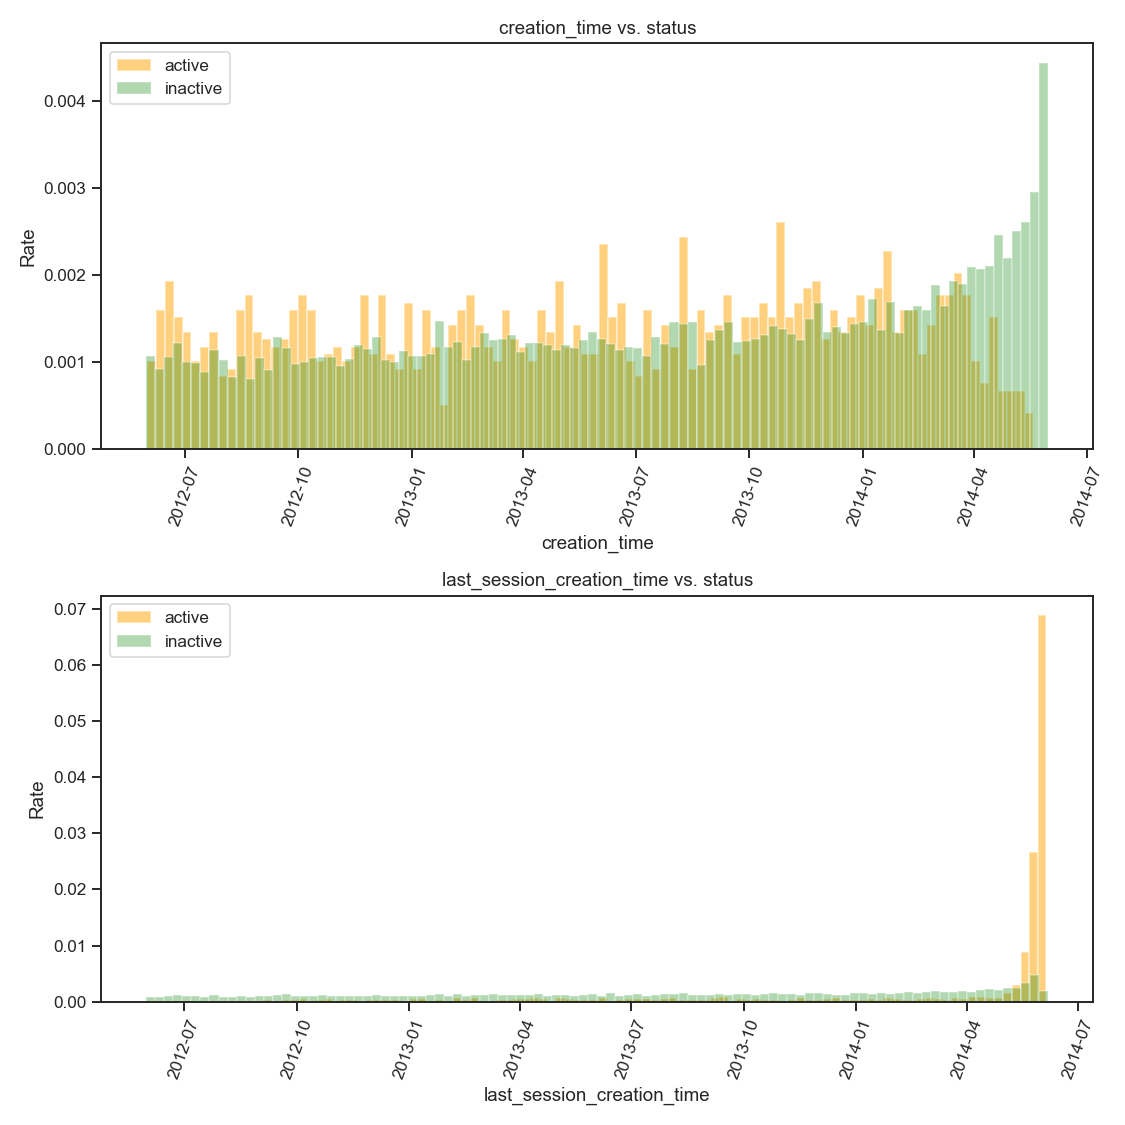

In [13]:
# Separate the data into 'active' and 'inactive'
df_active = df_users.query('status == 1')
df_inactive = df_users.query('status == 0')

# Date columns
date_columns = ['creation_time', 'last_session_creation_time']

# Plot histograms
plt.figure(figsize=(10,10))

for n in range(2):
    plt.subplot(2,1,n+1)
    plt.hist(df_active[date_columns[n]], histtype='bar', bins=100, alpha=0.5, color='orange', 
             label='active', density=True) 
    plt.hist(df_inactive[date_columns[n]], histtype='bar', bins=100, alpha=0.3, color='green', 
             label='inactive', density=True)
    plt.xlabel('%s'%date_columns[n])
    plt.ylabel('Rate')
    plt.xticks(rotation=70) 
    plt.legend(['active', 'inactive'])
    plt.title('%s vs. status'%date_columns[n])

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9) 
plt.tight_layout()
plt.show()

According to the plots, **newer users tend to be inactive** and **users who recently logged in are active**.  Because datetime objects are not able to be used for building a model, make new columns that explain these.

In [14]:
# Make a new column representing how old their accounts were
df_users['account_age'] = max(df_users['last_session_creation_time']) - df_users['creation_time']
df_users['account_age'] = df_users['account_age'].dt.days

# Make a new column representing how recently users logged in
df_users['recent_login'] = max(df_users['last_session_creation_time']) - df_users['last_session_creation_time']
df_users['recent_login'] = df_users['recent_login'].dt.days

df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status,account_age,recent_login
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,45,45
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,203,67
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,443,443
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,381,380
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,505,500


Next, take care of categorical columns having a lot of classes ("email", "org_id", and "invited_by_user_id"). If a lot of classes were used to create a model, the dimensions would become very high and could cause less performance.  
  
These preprocessing would be needed:  
   
- "**email**": extract the domains, and check the frequencies of the domains    
- "**org_id**": count the number of organizations, and check the frequencies of the organizations   
- "**invited_by_user_id**": fill in the missing values with 0 (0: no one or unknown), and check the frequency of each user_id   

In [15]:
# "email" column
# Extract domain names from the "email" column
df_users.replace(r'^[a-zA-Z0-9_.+-]+@', '', regex=True, inplace=True)

# Show the number of email domains
print('Number of email domains', df_users['email'].nunique())

# Show the popular email domains
df_users['email'].value_counts()[:10]

Number of email domains 1184


gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
mumdc.com            2
qgjbc.com            2
luque.com            2
rerwl.com            2
Name: email, dtype: int64

There were 1,184 kinds of domains, but only six of them were popular. Leave the six domains and replace the rest of them as "minor" to reduce the complexity.

In [16]:
# List up the major domains
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']

# Make a list that has replaced domainds
email_adjusted = []
for domain in df_users['email']:
    if domain in major_domains:
        email_adjusted.append(domain)
    else:
        email_adjusted.append('minor')

# Rewrite the adjusted domains on the "email" column
df_users['email'] = email_adjusted
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status,account_age,recent_login
0,1,2014-04-22 03:53:30,Clausen August,yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,45,45
1,2,2013-11-15 03:45:04,Poole Matthew,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,203,67
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,443,443
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,381,380
4,5,2013-01-17 10:14:20,Raw Grace,yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,505,500


In [17]:
# "org_id" column
# Show the number of "org_id"
print('Number of org_id', df_users['org_id'].nunique())

# Show the popular "org_id"
df_users['org_id'].value_counts()[:15]

Number of org_id 417


0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
8      97
14     87
11     75
12     75
17     74
Name: org_id, dtype: int64

The "org_id" had 417 classes, and the classes were relatively widespread. I decided to **remove this column** to built a model.

In [18]:
# "invited_by_user_id" column
# Fill in missing values in the "invited_by_user_id" column
df_users.fillna({'invited_by_user_id':0}, inplace=True)

# Change the data type into int because user_id is int
df_users['invited_by_user_id'] = df_users['invited_by_user_id'].astype(np.int64)

# Show the number of "invited_by_user_id"
print('Number of invited_by_user_id', df_users['invited_by_user_id'].nunique())

# Show the popular "invited_by_user_id"
df_users['invited_by_user_id'].value_counts()[:10]

Number of invited_by_user_id 2565


0        5583
10741      13
2527       12
11770      11
2308       11
1525       11
4302       10
10481      10
2354       10
4803       10
Name: invited_by_user_id, dtype: int64

The "invited_by_user_id" had 2,565 classes. The **largest class 46.5% (5,583/12k) was 0**, that is, users who were **not invited by anyone**. The other classes had fewer than 13 (very widespread). I decided to **change the column into binary classes** (0: not invited by anyone, 1: invited).  

In [19]:
# Change the column into binary classes** (0: not invited by anyone, 1: invited)
invited = list(df_users['invited_by_user_id'])
for i in range(12000):
    if df_users.loc[i, 'invited_by_user_id'] != 0:
        df_users.loc[i, 'invited_by_user_id'] = 1

df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status,account_age,recent_login
0,1,2014-04-22 03:53:30,Clausen August,yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0,45,45
1,2,2013-11-15 03:45:04,Poole Matthew,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,1,203,67
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0,443,443
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,0,381,380
4,5,2013-01-17 10:14:20,Raw Grace,yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,0,505,500


The columns that had a lot of classes have been treated. Next, show histograms and bar plots of the features.

<IPython.core.display.Javascript object>


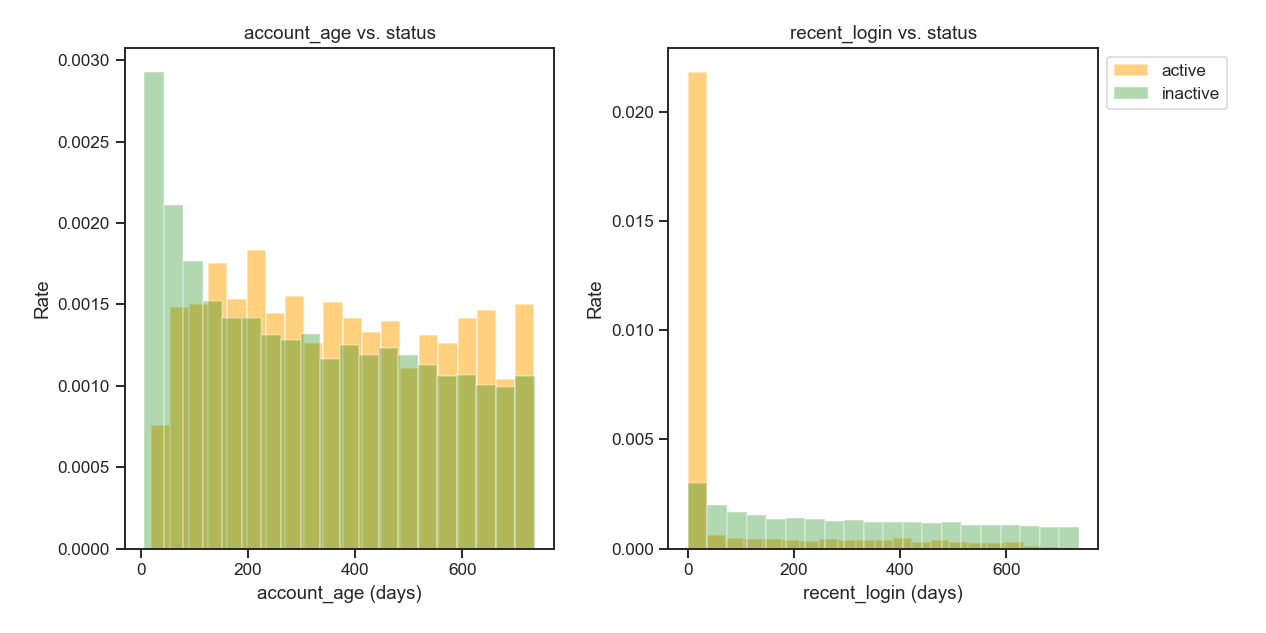

In [20]:
# Separate the data into 'active' and 'inactive' again
df_active = df_users.query('status == 1')
df_inactive = df_users.query('status == 0')

# Numeric columns
numeric_columns = ['account_age', 'recent_login']

# Plot histograms
plt.figure(figsize=(10,5))

for n in range(2):
    plt.subplot(1,2,n+1)
    plt.hist(df_active[numeric_columns[n]], histtype='bar', bins=20, alpha=0.5, color='orange', 
             label='active', density=True) 
    plt.hist(df_inactive[numeric_columns[n]], histtype='bar', bins=20, alpha=0.3, color='green', 
             label='inactive', density=True)
    plt.xlabel('%s (days)'%numeric_columns[n])
    plt.ylabel('Rate')
    plt.title('%s vs. status'%numeric_columns[n])

plt.legend(['active', 'inactive'], loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9) 
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


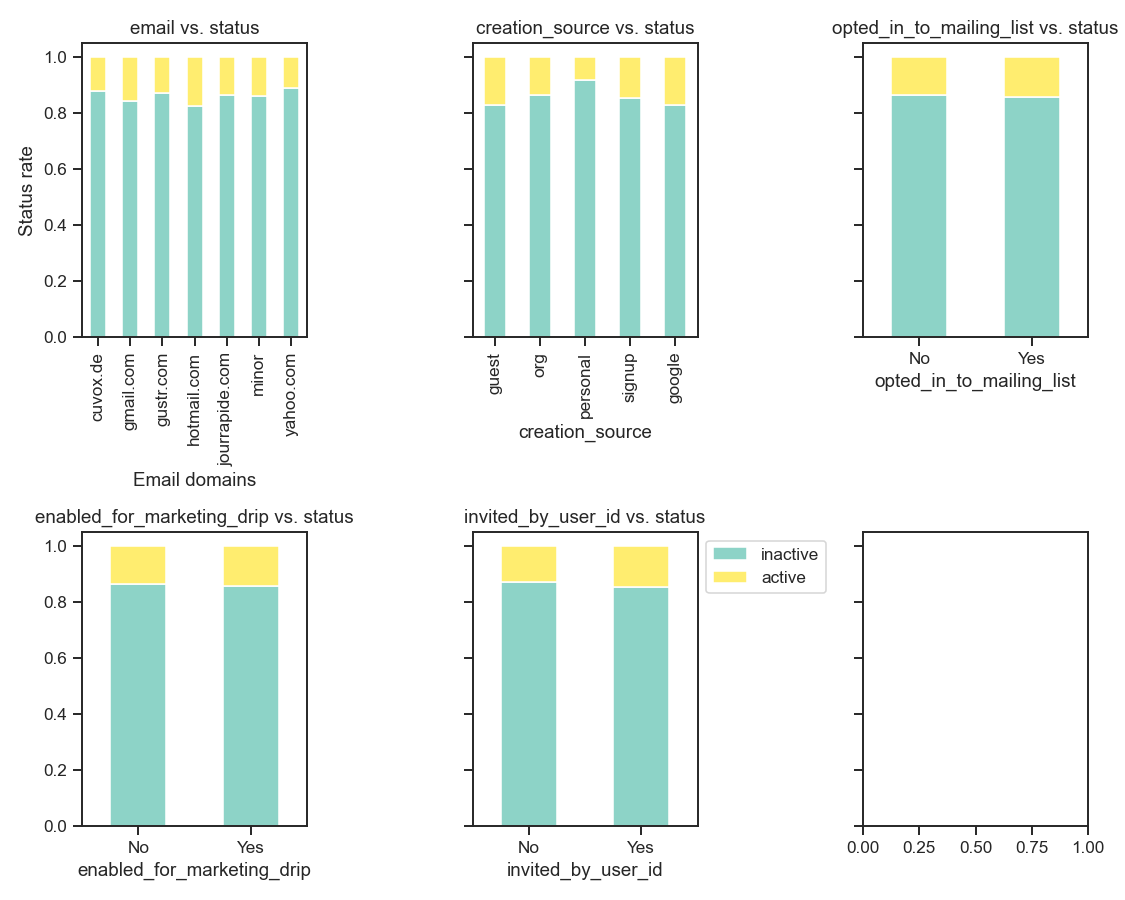

In [21]:
# Prepare for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,8), sharey=True)

# "email" column
# plot a stacked bar plot 
df_cross_email = pd.crosstab(df_users['email'], df_users['status'], normalize='index')
ax1 = df_cross_email.plot.bar(stacked=True, colormap='Set3', title='email vs. status', rot=90, ax=axes[0, 0], legend=False)
ax1.set_xlabel('Email domains')
ax1.set_ylabel('Status rate')

# "creation_source" column
# plot a stacked bar plot 
df_cross_creation_source = pd.crosstab(df_users['creation_source'], df_users['status'], normalize='index')
ax2 = df_cross_creation_source.plot.bar(stacked=True, colormap='Set3', title='creation_source vs. status', rot=90, ax=axes[0,1], legend=False)
ax2.set_xlabel('creation_source')
ax2.set_xticklabels(['guest', 'org', 'personal', 'signup', 'google'])

# "opted_in_to_mailing_list" column
# plot a stacked bar 
df_cross_mailing_list = pd.crosstab(df_users['opted_in_to_mailing_list'], df_users['status'], normalize='index')
ax3 = df_cross_mailing_list.plot.bar(stacked=True, colormap='Set3', title='opted_in_to_mailing_list vs. status', rot=0, ax=axes[0,2], legend=False)
ax3.set_xlabel('opted_in_to_mailing_list')
ax3.set_xticklabels(['No', 'Yes'])

# "enabled_for_marketing_drip" column
# plot a stacked bar 
df_cross_marketing_drip = pd.crosstab(df_users['enabled_for_marketing_drip'], df_users['status'], normalize='index')
ax4 = df_cross_marketing_drip.plot.bar(stacked=True, colormap='Set3', title='enabled_for_marketing_drip vs. status', rot=0, ax=axes[1,0], legend=False)
ax4.set_xlabel('enabled_for_marketing_drip')
ax4.set_xticklabels(['No', 'Yes'])

# "invited_by_user_id" column
# plot a stacked bar 
df_cross_marketing_drip = pd.crosstab(df_users['invited_by_user_id'], df_users['status'], normalize='index')
ax5 = df_cross_marketing_drip.plot.bar(stacked=True, colormap='Set3', title='invited_by_user_id vs. status', rot=0, ax=axes[1,1])
ax5.set_xlabel('invited_by_user_id')
ax5.legend(['inactive', 'active'], loc='upper left', bbox_to_anchor=(1, 1)) 
ax5.set_xticklabels(['No', 'Yes'])

plt.subplots_adjust(left=0.1, right=0.85, bottom=0.25, top=0.9) 
plt.tight_layout()

According to the plots, the values of the **"account_age" and "recent_login"** columns had different tendencies depending on the account status.  
  
Get the target and the features that are used to create a model as different DataFrames, and transform the categorical columns into dummy variables. Then, split the DataFrams into a train set and a test set so that the test set can be used to evaluate the predictive model.

In [22]:
# Extract features used to make a model, and target values
df_features = df_users.drop(['object_id', 'creation_time','name', 'last_session_creation_time', 'org_id', 'status'], axis=1)
df_target = df_users['status']

# Convert the categorical features into dummy variables
df_num_features = pd.get_dummies(df_features, columns=['creation_source', 'email'], drop_first=True)

# Divide the data into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(df_num_features, df_target, test_size = 0.3, random_state=1)

## 2. Creating a predictive model

Now the data is ready to be used to create a model. Although there are many kinds of classifiers that can be used for this problem, I try **Random Forest** and **Gradient Boosting Decision Tree** because many features are categorical and the classifiers often provide high performance to them.  

In [23]:
# Define a function turning parameters, training a model with a train set, and test the performance of the model 
def tuning_train_predict(clf, X_train, y_train, X_test, y_test, param_grid):
    # Find the best parameters
    gs_cv = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=2) #, scoring='f1'
    gs_cv.fit(X_train, y_train)
    print('Best parameters:', gs_cv.best_params_)
    print('Best f1 score on the train set:', round(gs_cv.best_score_, 3))
        
    # Predict the classes on the test data
    y_pred = gs_cv.predict(X_test)
    
    # Make a DataFrame of a confusion matrix
    df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['inactive', 'active'], columns=['inactive', 'active'])
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    print('--------------------------------------------------------')
    print(df)
    print('--------------------------------------------------------')
    
    # Print a classification report
    print(classification_report(y_test, y_pred, target_names=['inactive', 'active']))

**Random Forest**

In [24]:
%%time

param_grid = {'n_estimators':[100, 150, 200], 
              'max_depth':[20, 30, 40], 
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [5, 10, 20],
              'criterion':['entropy', 'gini']} 

rf = RandomForestClassifier(class_weight='balanced', n_jobs=2, random_state=1)
tuning_train_predict(rf, X_train, y_train, X_test, y_test, param_grid=param_grid)

Best parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best f1 score on the train set: 0.854
--------------------------------------------------------
Predicted  inactive  active
Actual                     
inactive       3037      35
active          106     422
--------------------------------------------------------
              precision    recall  f1-score   support

    inactive       0.97      0.99      0.98      3072
      active       0.92      0.80      0.86       528

    accuracy                           0.96      3600
   macro avg       0.94      0.89      0.92      3600
weighted avg       0.96      0.96      0.96      3600

Wall time: 4min 43s


**Gradient Boosting Decision Tree**

In [25]:
%%time

# Parameters to tune
param_grid = {'eta':[0.1, 0.2, 0.3],
              'gamma':[0, 1, 3], 
              'max_depth':[2, 5, 10],
              'min_child_weight':[0, 1, 2],
              'subsample':[0.8, 1]} 

gbdt = XGBClassifier(objective='binary:logistic', random_state=1, scale_pos_weight=round(len(df_inactive)/len(df_active)))
tuning_train_predict(gbdt, X_train, y_train, X_test, y_test, param_grid=param_grid)

Best parameters: {'eta': 0.1, 'gamma': 0, 'max_depth': 2, 'min_child_weight': 0, 'subsample': 0.8}
Best f1 score on the train set: 0.891
--------------------------------------------------------
Predicted  inactive  active
Actual                     
inactive       3023      49
active           60     468
--------------------------------------------------------
              precision    recall  f1-score   support

    inactive       0.98      0.98      0.98      3072
      active       0.91      0.89      0.90       528

    accuracy                           0.97      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.97      0.97      0.97      3600

Wall time: 3min 53s


**Gradient boosting decision tree** (GBDT) provided better performance. The positive rate (the rate of active users) was 14%, and the data was **imbalanced**. That was why the **f1 score** was used to tune the parameters and evaluate the model. If Relax inc. wants to pick up all potential users who could adopt and doesn't mind that some false positives would be included, it would be one choice to use "recall" as the metric of the performances because recall represents how many positive samples were labeled as positive. 

On the GBDT model, the f1 score on the train set was 0.891, and 0.90 on the test set. The scores were very close, and it is said the model was **not overfitting**.  
  
Here, see what are the most important features.

<IPython.core.display.Javascript object>


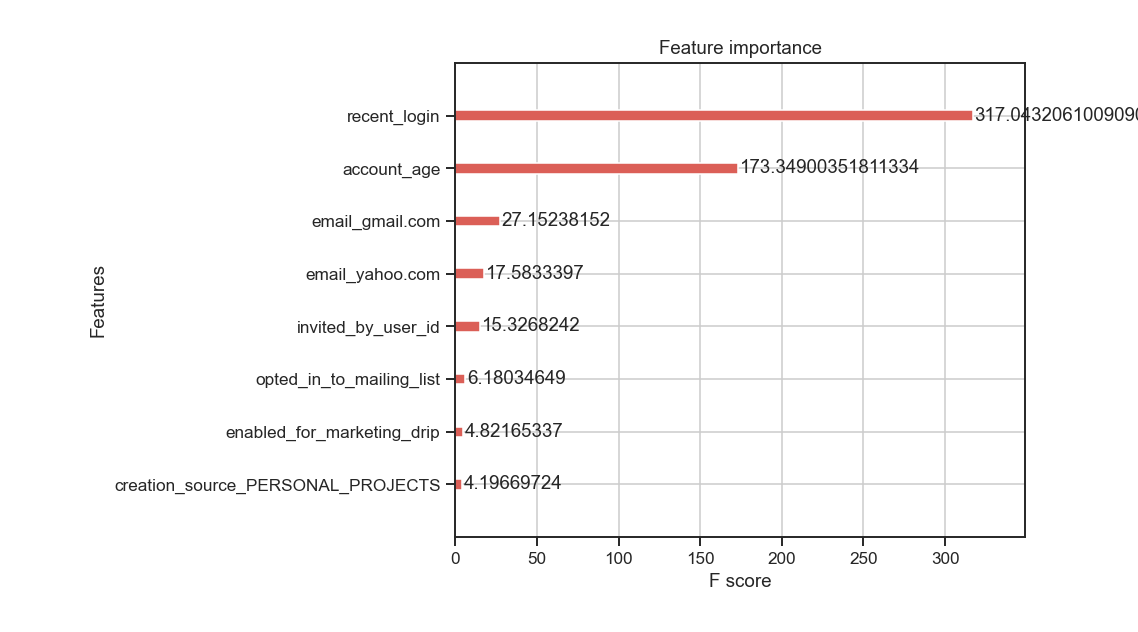

In [26]:
# Train a model with the best parameters
xgb_best = XGBClassifier(objective='binary:logistic', random_state=1, eta=0.1, gamma=0, max_depth=2, 
                         min_child_weight=0, subsample=0.8, scale_pos_weight=round(len(df_inactive)/len(df_active)))

xgb_best.fit(X_train, y_train)

# Plot the feature importance
ax6 = plot_importance(xgb_best, importance_type='gain')
fig6 = ax6.figure
fig6.set_size_inches(9, 5)
plt.subplots_adjust(left=0.4, right=0.9, bottom=0.15, top=0.9) 

According to the plot, the most important factors to predict future user adoption were "**acount_age**" and "**recnet_login**". Their scores were predominantly higher than the others. Users who recently logged in and users who are long-term customers tend to adopt the product. **E-mail domains** and whether a user was **invited by anyone** would also have some impacts on the prediction. For example, users using Gmail or yahoo mail were more likely to be active. 